In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn 
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [4]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [5]:
df.sample()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
1662,Intex,£7.48,30 new,78,7.0,4.3 out of 5 stars,Sports Toys & Outdoor > Beach Toys > Paddling ...


In [6]:
df.shape

(10000, 7)

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

Запишем в переменную NaNsAmount кол-во nan`ов в каждом столбце.

In [7]:
NaNsAmount = df.isnull().sum()
NaNsAmount

manufacturer                           7
price                               1435
number_available_in_stock           2500
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64

Определим их отношение к общему кол-ву данных.

In [8]:
NaNsAmount / (df.size / df.columns.size)

manufacturer                        0.0007
price                               0.1435
number_available_in_stock           0.2500
number_of_reviews                   0.0018
number_of_answered_questions        0.0765
average_review_rating               0.0018
amazon_category_and_sub_category    0.0690
dtype: float64

In [9]:
NaNsAmount.sum() / df.size

0.07761428571428572

Особенно много nan`ов в столбце number_available_in_stock. Поэтому можно удалить данный столбец.
Посмотрим, что у нас вышло в итоге.

In [10]:
df = df.drop(columns = ['number_available_in_stock'])
df.sample()

,manufacturer,price,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
322,Harrods,NaN,1,1.0,5.0 out of 5 stars,NaN


In [11]:
df.shape

(10000, 6)

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

Посмотрим на кол-во nan`ов и типы столбцов.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      9993 non-null   object 
 1   price                             8565 non-null   object 
 2   number_of_reviews                 9982 non-null   object 
 3   number_of_answered_questions      9235 non-null   float64
 4   average_review_rating             9982 non-null   object 
 5   amazon_category_and_sub_category  9310 non-null   object 
dtypes: float64(1), object(5)
memory usage: 468.9+ KB


Много данных хранятся вперемешку в виде строк и чисел с плавующей запятой, поэтому следует привести все к одному типу - float.
Напишем простейшую функцию перевода. (т.к. тысячи отмечаются символом ',', следует заменить его в каждой строке).

In [13]:
def strToFloat(UserStr):
  UserStr = UserStr.replace(',', '')
  return float(UserStr)

Есть некоторые сложности перевода цен в float: некоторые значения являются nan и некоторые значения являются диапозонами цен (299-600 например).
Первая проблема решается наложение условия на тип данных. Вторая - при помощи определения кол-ва элементов массива после сплита.

In [14]:
for i in range(0, len(df.price)):
  if (isinstance(df.price[i], str)):
    if (len(df.price[i].split('-')) == 1):
      df.price[i] = strToFloat(df.price[i][1:])
    else:
      df.price[i] = (strToFloat(df.price[i].split('- ')[0][1:]) + strToFloat(df.price[i].split('- ')[1][1:]))/2
  else:
    df.price[i] = 0
  

<ipython-input-14-9d63823b4530>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price[i] = strToFloat(df.price[i][1:])
<ipython-input-14-9d63823b4530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price[i] = 0
<ipython-input-14-9d63823b4530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price[i] = 0
<ipython-input-14-9d63823b4530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

По такому же принципу заменим данные в столбце average_review_rating.

In [15]:
for i in range(0, len(df.average_review_rating)):
  if (isinstance(df.average_review_rating[i], str)):
    df.average_review_rating[i] = strToFloat(df.average_review_rating[i].split()[0])
  else:
    df.average_review_rating[i] = 0

<ipython-input-15-457cba9d19ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.average_review_rating[i] = strToFloat(df.average_review_rating[i].split()[0])
<ipython-input-15-457cba9d19ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.average_review_rating[i] = 0
<ipython-input-15-457cba9d19ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.average_review_rating[i] = strToFloat(df.average_review_rating[i].split()[0])
<i

Текстовое представление произвотеля можно убрать.

In [16]:
df = df.drop(columns = ['manufacturer'])

Теперь закодируем значения данных о категории товара. Разделим их на 5 подкатегории.

In [17]:
newDf = df.amazon_category_and_sub_category.str.split(' > ', expand=True) #Создаем новый df с кол-вом столбцов, равным нужному кол-ву подкатегорий
newDf.columns=['sub_category_0','sub_category_1','sub_category_2', 'sub_category_3', 'sub_category_4'] #Называем их

finalDf = pd.concat([df,newDf], axis = 1) #Соединяем в конечный df
finalDf = finalDf.drop(columns = ['amazon_category_and_sub_category'], axis = 1) #Убираем старый столбец

df = finalDf

Представи подкатегории в виде факториала.

In [18]:
#факторизируем значение каждой ячейки столбцов
df.sub_category_0 = pd.factorize(df.sub_category_0)[0] + 1
df.sub_category_1 = pd.factorize(df.sub_category_1)[0] + 1
df.sub_category_2 = pd.factorize(df.sub_category_2)[0] + 1
df.sub_category_3 = pd.factorize(df.sub_category_3)[0] + 1
df.sub_category_4 = pd.factorize(df.sub_category_4)[0] + 1

Посмотрим на конечный результат.

In [19]:
df.sample()

,price,number_of_reviews,number_of_answered_questions,average_review_rating,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4
5257,1.95,21,2.0,4.3,7,90,0,0,0


Осталось только заполнить последние пропуски.

In [20]:
df = df.fillna(0)

In [21]:
for i in range(0, len(df.price)):
  if (isinstance(df.number_of_reviews[i], str)):
    df.number_of_reviews[i] = strToFloat(df.number_of_reviews[i])
  if (isinstance(df.number_of_answered_questions[i], str)):
    df.number_of_answered_questions[i] = strToFloat(df.number_of_answered_questions[i])

<ipython-input-21-daac106cdb8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.number_of_reviews[i] = strToFloat(df.number_of_reviews[i])
<ipython-input-21-daac106cdb8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.number_of_reviews[i] = strToFloat(df.number_of_reviews[i])


# Обучение модели (3 балла)

Описываем модель.

In [22]:
from sklearn.model_selection import train_test_split
Y = df['price']
X = df.drop(columns = ['price'])
trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.8, random_state=42)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

Обучим DummyRegressor`а и ...

In [23]:
from sklearn.dummy import DummyRegressor

dummyRegres = DummyRegressor(strategy="mean")
dummyRegres.fit(trainX, trainY)
predictY = dummyRegres.predict(testX)

... получим нужные значения.

In [24]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

MSE = mse(testY, predictY)
RMSE = np.sqrt(MSE)
R2 = r2_score(testY, predictY)

print(MSE)
print(RMSE)
print(R2)

1194.64771021695
34.56367616757439
-0.004612250910162263


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

Обучение регрессионного дерева решений и ...

In [25]:
from sklearn.tree import DecisionTreeRegressor

dTTree = DecisionTreeRegressor()
dTTree = dTTree.fit(trainX, trainY)
predictY = dTTree.predict(testX)

... получение нужных значений

In [26]:
r2_score(testY, predictY)

-0.19245690539242521

Качество ,по сравнению с DummyRegressor, сильно хуже.

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

Обучние линейной регрессии и ...

In [27]:
from sklearn.linear_model import LinearRegression

LinearRegress = LinearRegression()
LinearRegress = LinearRegress.fit(trainX, trainY)

predictY = LinearRegress.predict(testX)

... получение нужных значений.

In [28]:
r2_score(testY, predictY)

-0.014236787151210128

Значение показывает, что линейная регрессия работает лучше, чем дерево решений, но хуже, чем DummyRegressor.

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

Опишем функцию нахождения предсказания Y для каждого параметра и изобразим на основе этого график.

In [29]:
import seaborn as sns

def PFC (parameter: str, values: list, trX = trainX, tsX = testX, trY = trainY, tsY = testY):

    trainCurve = []
    testCurve = []

    for value in values:

        treeModel = DecisionTreeRegressor(**{parameter: value})
        treeModel.fit(trX, trY)

        predictTrainY = treeModel.predict(trX)
        predictTestY =  treeModel.predict(tsX)
        
        trainCurve.append(r2_score(trY, predictTrainY))
        testCurve.append(r2_score(tsY, predictTestY))

    sns.lineplot(x=values, y=trainCurve, label='train')
    sns.lineplot(x=values, y=testCurve, label='test')

График для максимальной глубины дерева - выбираем тут 5.

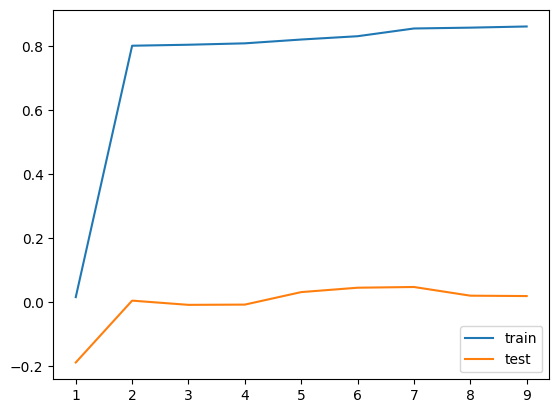

In [30]:
PFC('max_depth', np.arange(1, 10))

Тут берем 3.

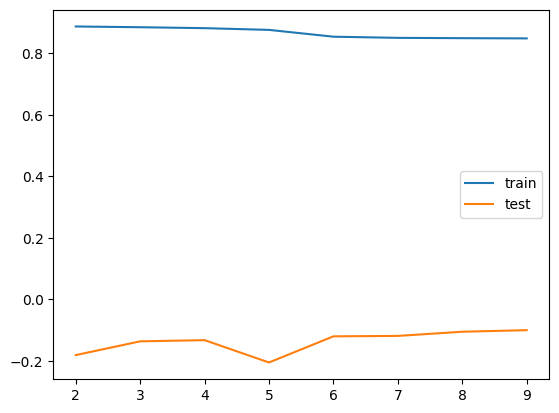

In [31]:
PFC('min_samples_split', np.arange(2, 10))

Тут же берем 2.

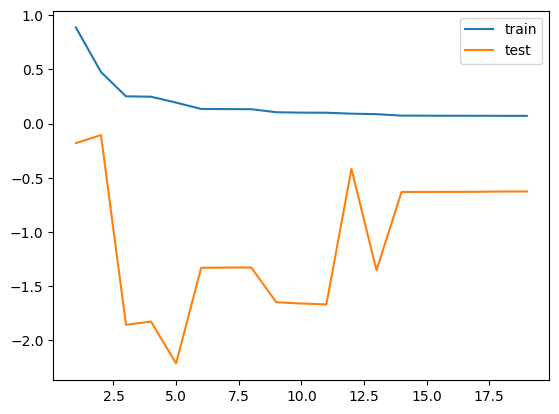

In [32]:
PFC('min_samples_leaf', np.arange(1, 20, 1))

Построим дерево на основе найденных параметров.

In [33]:
parameterTree = DecisionTreeRegressor(max_depth=5, min_samples_split=3, min_samples_leaf=2)
parameterTree.fit(trainX, trainY)
predictY = parameterTree.predict(testX)

In [34]:
MSE = mse(testY, predictY)
RMSE = np.sqrt(MSE)
R2 = r2_score(testY, predictY)

print(MSE)
print(RMSE)
print(R2)

1180.9456618519575
34.36488995838569
0.006910179955699647


Результаты на этот раз намного лучше! Полученные значения очень близки к значениям DummyRegressor!

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [35]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

Обучим ансамбль!

In [ ]:
ens = EnsembleTreeRegressor()
ens.fit(trainX, trainY)
predictY = ens.predict(testX)

И получим значения для сравнения с прошлыми результатами.

In [ ]:
MSE = mse(testY, predictY)
RMSE = np.sqrt(MSE)
R2 = r2_score(testY, predictY)

print(MSE)
print(RMSE)
print(R2)